![QuantConnect Logo](https://cdn.quantconnect.com/web/i/icon.png)
<hr>

<Axes: >

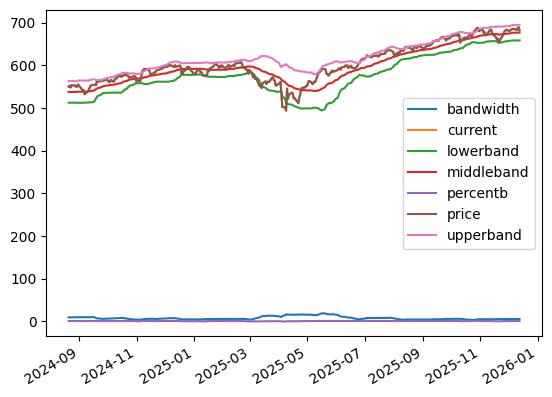

In [1]:
# QuantBook Analysis Tool
# For more information see [https://www.quantconnect.com/docs/v2/our-platform/research/getting-started]
qb = QuantBook()
spy = qb.add_equity("SPY")
history = qb.history(qb.securities.keys(), 360, Resolution.DAILY)

# Indicator Analysis
bbdf = qb.indicator(BollingerBands(30, 2), spy.symbol, 360, Resolution.DAILY)
bbdf.drop('standarddeviation', axis=1).plot()

In [ ]:
# Autocorrelation Analysis of Top 5 Most Autocorrelated Stocks in 2020 (QC500-like Universe)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf
from datetime import datetime

qb = QuantBook()
qb.set_start_date(2020, 1, 1)

# Get QC500-like universe using ETF constituents (SPY + QQQ + IWM covers most of QC500)
spy_constituents = qb.universe.etf("SPY", Market.USA, datetime(2020, 1, 2))
qqq_constituents = qb.universe.etf("QQQ", Market.USA, datetime(2020, 1, 2))

# Combine and deduplicate
all_constituents = list(set(spy_constituents + qqq_constituents))
print(f"Found {len(all_constituents)} unique symbols from SPY + QQQ ETFs")

# Add all symbols
symbols = []
for constituent in all_constituents[:500]:  # Limit to 500 like QC500
    try:
        symbols.append(qb.add_equity(constituent.symbol.value).symbol)
    except:
        pass

print(f"Successfully added {len(symbols)} symbols")

# Get 2020 data
history = qb.history(symbols, 252, Resolution.DAILY)

# Extract close prices and calculate returns  
prices = history['close'].unstack(level=0)
returns = prices.pct_change().dropna()

# Filter stocks with enough data (at least 200 days)
valid_cols = returns.columns[returns.count() >= 200]
returns = returns[valid_cols]
prices = prices[valid_cols]

print(f"Analyzing {len(returns.columns)} stocks with sufficient data")

# Calculate autocorrelation (lag-1) for each stock - SAME AS YOUR STRATEGY
autocorrelations = returns.apply(lambda x: x.autocorr()).dropna().sort_values(ascending=False)

print("\n" + "="*60)
print("TOP 15 MOST AUTOCORRELATED (Your Momentum Candidates)")
print("="*60)
for s in autocorrelations.head(15).index:
    print(f"  {str(s).split(' ')[0]:6s}: {autocorrelations[s]:.4f}")

print("\n" + "="*60)
print("BOTTOM 15 LEAST AUTOCORRELATED (Your Mean Reversion Candidates)")
print("="*60)
for s in autocorrelations.tail(15).index:
    print(f"  {str(s).split(' ')[0]:6s}: {autocorrelations[s]:.4f}")

In [ ]:
# Plot ACF for Top 5 Most Autocorrelated Stocks from QC500-like Universe
top_5_symbols = autocorrelations.head(5).index.tolist()
top_5_names = [str(s).split(' ')[0] for s in top_5_symbols]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# ACF plots for each of the top 5
for idx, (symbol, name) in enumerate(zip(top_5_symbols, top_5_names)):
    stock_returns = returns[symbol].dropna()
    acf_values = acf(stock_returns, nlags=20)
    ax = axes.flatten()[idx]
    ax.bar(range(len(acf_values)), acf_values, color='steelblue', alpha=0.7)
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax.axhline(y=1.96/np.sqrt(len(stock_returns)), color='red', linestyle='--', alpha=0.5, label='95% CI')
    ax.axhline(y=-1.96/np.sqrt(len(stock_returns)), color='red', linestyle='--', alpha=0.5)
    ax.set_title(f'{name}\nLag-1 Autocorr: {autocorrelations[symbol]:.4f}')
    ax.set_xlabel('Lag')
    ax.set_ylabel('ACF')

# Hide the 6th subplot
axes[1, 2].axis('off')
axes[1, 2].text(0.5, 0.5, 'Red dashed = 95% CI\nBars outside = significant', 
                ha='center', va='center', fontsize=12, transform=axes[1, 2].transAxes)

plt.suptitle('ACF of Top 5 Most Autocorrelated Stocks (QC500 Universe) - 2020', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# Plot Cumulative Returns: Top 5 vs Bottom 5 Autocorrelated Stocks (QC500 Universe)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top 5 (High autocorrelation = YOUR momentum candidates)
top_5 = autocorrelations.head(5).index.tolist()
for symbol in top_5:
    name = str(symbol).split(' ')[0]
    cum_ret = (1 + returns[symbol]).cumprod()
    axes[0].plot(cum_ret.values, label=f'{name} ({autocorrelations[symbol]:.3f})', linewidth=2)
axes[0].set_title('Top 5 Most Autocorrelated\n(Your Momentum Candidates) - 2020', fontsize=12)
axes[0].set_xlabel('Trading Days')
axes[0].set_ylabel('Cumulative Return (1 = starting value)')
axes[0].legend(loc='upper left')
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=1.0, color='black', linestyle='--', alpha=0.3)

# Bottom 5 (Low/negative autocorrelation = YOUR mean reversion candidates)
bottom_5 = autocorrelations.tail(5).index.tolist()
for symbol in bottom_5:
    name = str(symbol).split(' ')[0]
    cum_ret = (1 + returns[symbol]).cumprod()
    axes[1].plot(cum_ret.values, label=f'{name} ({autocorrelations[symbol]:.3f})', linewidth=2)
axes[1].set_title('Bottom 5 Least Autocorrelated\n(Your Mean Reversion Candidates) - 2020', fontsize=12)
axes[1].set_xlabel('Trading Days')
axes[1].set_ylabel('Cumulative Return (1 = starting value)')
axes[1].legend(loc='upper left')
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=1.0, color='black', linestyle='--', alpha=0.3)

plt.suptitle('Cumulative Returns: High vs Low Autocorrelation Stocks (QC500 Universe) - 2020', fontsize=14)
plt.tight_layout()
plt.show()

# Summary statistics
print("\n" + "="*70)
print("PERFORMANCE SUMMARY - 2020")
print("="*70)

print(f"\nTOP 5 Autocorrelated (Momentum Candidates):")
top_5_returns = []
for s in top_5:
    total_ret = (1 + returns[s]).prod() - 1
    top_5_returns.append(total_ret)
    print(f"  {str(s).split(' ')[0]:6s}: {total_ret:+7.1%} return (autocorr: {autocorrelations[s]:.4f})")
print(f"  {'AVERAGE':6s}: {np.mean(top_5_returns):+7.1%}")

print(f"\nBOTTOM 5 Autocorrelated (Mean Reversion Candidates):")
bottom_5_returns = []
for s in bottom_5:
    total_ret = (1 + returns[s]).prod() - 1
    bottom_5_returns.append(total_ret)
    print(f"  {str(s).split(' ')[0]:6s}: {total_ret:+7.1%} return (autocorr: {autocorrelations[s]:.4f})")
print(f"  {'AVERAGE':6s}: {np.mean(bottom_5_returns):+7.1%}")

print(f"\n>>> High autocorr avg: {np.mean(top_5_returns):+.1%} vs Low autocorr avg: {np.mean(bottom_5_returns):+.1%}")